# Quantum Integer Programming (QuIP) 47-779. Fall 2020, CMU

This notebook contains material from the Quantum Integer Programming Lecture at CMU Fall 2020 by David Bernal (bernalde at cmu.edu), Sridhar Tayur (stayur at cmu.edu) and Davide Venturelli; the content is available on **[Github](https://github.com/bernalde/QuIP)**. The text is released under the **[CC-BY-NC-ND-4.0](https://creativecommons.org/licenses/by-nc-nd/4.0/legalcode) license, and code is released under the **[MIT license](https://opensource.org/licenses/MIT).*

Run in **[Google Colab](https://colab.research.google.com/github/bernalde/QuIP/blob/master/notebooks/Notebook%207%20-%20DWave.ipynb)**

## Quantum Annealing via D-Wave
This notebook will give the first interaction with D-Wave's Quantum Annealer. It will use the QUBO modeling problem introduced earlier and will define it using D-Wave's package **[dimod](https://github.com/dwavesystems/dimod)**, and then solve them using **[neal](https://github.com/dwavesystems/dwave-neal)**'s implementation of simulated annealing classicaly and D-Wave system package to use Quantum Annealing.
We will also leverage the use of **[Networkx](https://networkx.github.io/)** for network models/graphs.

#### Problem statement
We define a QUBO as the following optimization problem:
$$
\min_{x \in \{0,1 \}^n} \sum_{(ij) \in E(G)} Q_{ij}x_i x_j + \sum_{i \in V(G)}Q_{ii}x_i + c_Q = \min_{x \in \{0,1 \}^n}  x^\top Q x + c_Q
$$
where we optimize over binary variables $x \in \{ 0,1 \}^n$, on a constrained graph $G(V,E)$ defined by an adjacency matrix $Q$. We also include an arbitrary offset  $c_Q$.

### Example
Suppose we want to solve the following problem via QUBO
$$
\min_{\mathbf{x}} 2𝑥_0+4𝑥_1+4𝑥_2+4𝑥_3+4𝑥_4+4𝑥_5+5𝑥_6+4𝑥_7+5𝑥_8+6𝑥_9+5𝑥_{10} \\
s.t. \begin{bmatrix}
1 & 0 & 0 & 1 & 1 & 1 & 0 & 1 & 1 & 1 & 1\\
0 & 1 & 0 & 1 & 0 & 1 & 1 & 0 & 1 & 1 & 1\\
0 & 0 & 1 & 0 & 1 & 0 & 1 & 1 & 1 & 1 & 1
\end{bmatrix}\mathbf{x}=
\begin{bmatrix}
1\\
1\\
1
\end{bmatrix} \\
\mathbf{x} \in \{0,1 \}^{11}
$$


In [1]:
# If using this on Google collab, we need to install the packages
try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False

# Let's install with dimod and neal
if IN_COLAB:
    !pip install dwave-ocean-sdk

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.4/50.4 kB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 71.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.9/158.9 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.5/77.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 52.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.7/6.7 MB 63.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.0/107.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 59.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 225.1/225.1 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2

In [2]:
# Import the Dwave packages dimod and neal
import dimod
import neal
# Import Matplotlib to generate plots
import matplotlib.pyplot as plt
# Import numpy and scipy for certain numerical calculations below
import numpy as np
from scipy.special import gamma
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx

First we would write this problem as a an unconstrained one by penalizing the linear constraints as quadratics in the objective. Let's first define the problem parameters

In [3]:
A = np.array([[1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1],
            [0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1],
            [0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1]])
b = np.array([1, 1, 1])
c = np.array([2, 4, 4, 4, 4, 4, 5, 4, 5,6, 5])

In order to define the $Q$ matrix, we write the problem
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x}\\
s.t. \mathbf{A}\mathbf{x}=\mathbf{b} \\
\mathbf{x} \in \{0,1 \}^{11}
$$
as follows:
$$
\min_{\mathbf{x}} \mathbf{c}^\top \mathbf{x} + \rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) \\
\mathbf{x} \in \{0,1 \}^{11}
$$
Exploting the fact that $x^2=x$ for $x \in \{0,1\}$, we can make the linear terms appear in the diagonal of the $Q$ matrix.
$$
\rho(\mathbf{A}\mathbf{x}-\mathbf{b})^\top (\mathbf{A}\mathbf{x}-\mathbf{b}) = \rho( \mathbf{x}^\top (\mathbf{A}^\top \mathbf{A}) \mathbf{x} - 2\mathbf{b}^\top \mathbf{A} \mathbf{x} + \mathbf{b}^\top \mathbf{b} )
$$
For this problem in particular, ona can prove the the penalization factor is given by $\rho > \sum_{i=1}^n |c_i|$, therefore we choose this bound + 1.

In [4]:
rho = np.sum(np.abs(c)) + 1
Q = rho*np.matmul(A.T,A)
Q += np.diag(c)
Q -= rho*2*np.diag(np.matmul(b.T,A))
cQ = rho*np.matmul(b.T,b)
print(Q)
print(cQ)


[[ -46    0    0   48   48   48    0   48   48   48   48]
 [   0  -44    0   48    0   48   48    0   48   48   48]
 [   0    0  -44    0   48    0   48   48   48   48   48]
 [  48   48    0  -92   48   96   48   48   96   96   96]
 [  48    0   48   48  -92   48   48   96   96   96   96]
 [  48   48    0   96   48  -92   48   48   96   96   96]
 [   0   48   48   48   48   48  -91   48   96   96   96]
 [  48    0   48   48   96   48   48  -92   96   96   96]
 [  48   48   48   96   96   96   96   96 -139  144  144]
 [  48   48   48   96   96   96   96   96  144 -138  144]
 [  48   48   48   96   96   96   96   96  144  144 -139]]
144


We can visualize the graph that defines this instance using the Q matrix as the adjacency matrix of a graph.

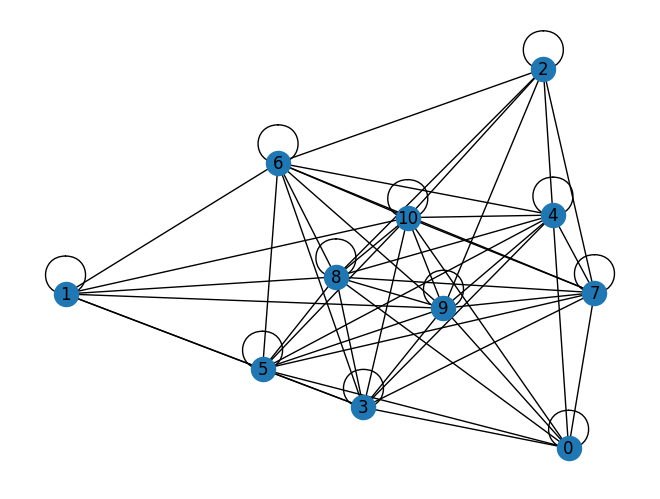

In [6]:
#G = nx.from_numpy_matrix(Q)
G = nx.from_numpy_array(Q)
nx.draw(G, with_labels=True)


Let's define a QUBO model and then solve it via simulated annealing.

In [7]:
model = dimod.BinaryQuadraticModel.from_qubo(Q, offset=cQ)



In [8]:
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by=None)]

    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    print("minimum energy:", min(energies))


def plot_energies(results, title=None):
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))

Let's now solve this problem using Simulated Annealing

In [9]:
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(model, num_reads=1000)


minimum energy: 5.0


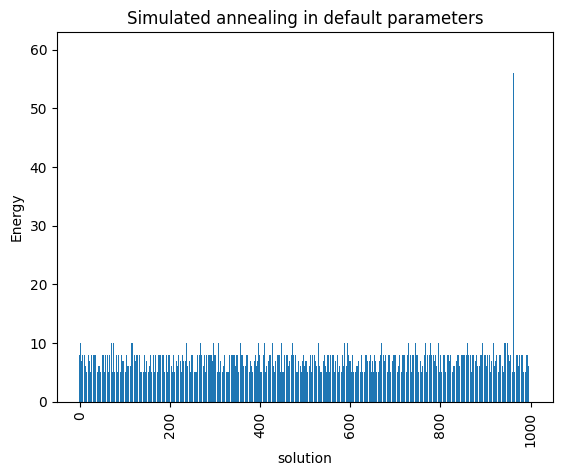

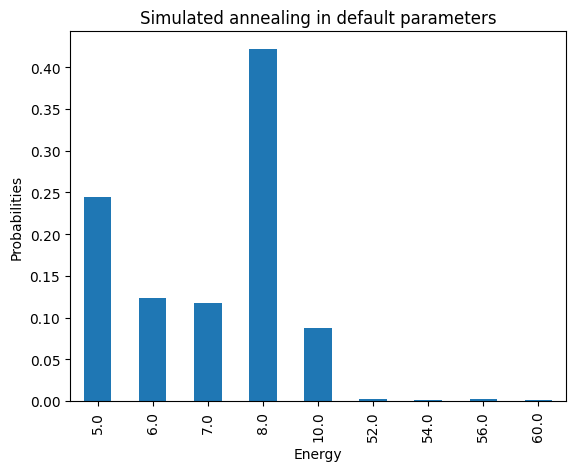

minimum energy: 5.0


In [10]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')

Notice that this is the same example we have been solving earlier (via Integer Programming in the Quiz 1, via Ising model in the Notebook 4, and via QUBO in Notebook 5).

## Now let's solve this using Quantum Annealing!

In [ ]:
# Let's setup the D-Wave connection
if IN_COLAB:
    !dwave setup

In [14]:
!dwave ping

Using endpoint: https://cloud.dwavesys.com/sapi/
Using region: na-west-1
Using solver: Advantage_system4.1
Submitted problem ID: 69e09b83-da89-4c54-ab5c-02eed4c6ccc8

Wall clock time:
 * Solver definition fetch: 746.995 ms
 * Problem submit and results fetch: 277.283 ms
 * Total: 1024.278 ms

QPU timing:
 * post_processing_overhead_time = 1.0 us
 * qpu_access_overhead_time = 47.66 us
 * qpu_access_time = 15855.34 us
 * qpu_anneal_time_per_sample = 20.0 us
 * qpu_delay_time_per_sample = 20.58 us
 * qpu_programming_time = 15778.36 us
 * qpu_readout_time_per_sample = 36.4 us
 * qpu_sampling_time = 76.98 us
 * total_post_processing_time = 1.0 us


In [15]:
import dwave_networkx as dnx
from dwave.system import (DWaveSampler, EmbeddingComposite,
                          FixedEmbeddingComposite)
from pprint import pprint

Advantage_system4.1
Number of qubits= 5627
Number of couplers= 40279


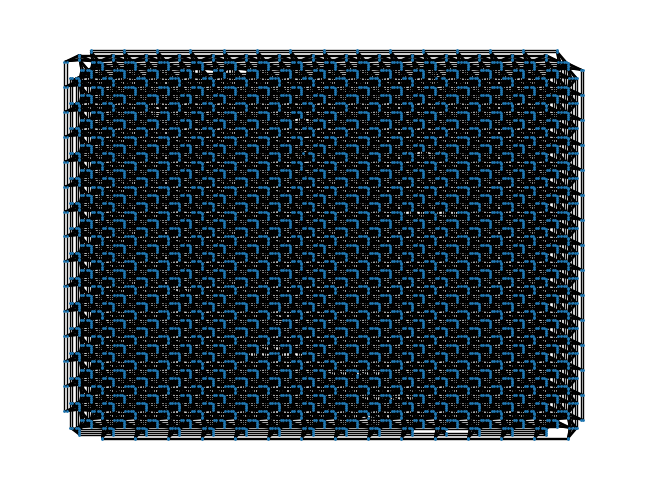

In [20]:
# Graph corresponding to D-Wave 2000Q
qpu = DWaveSampler()
qpu_edges = qpu.edgelist
qpu_nodes = qpu.nodelist
# pprint(dir(qpu))
if qpu.solver.id == "DW_2000Q_6":
    print(qpu.solver.id)
    X = dnx.chimera_graph(16, node_list=qpu_nodes, edge_list=qpu_edges)
    dnx.draw_chimera(X, node_size=1)
    print('Number of qubits=', len(qpu_nodes))
    print('Number of couplers=', len(qpu_edges))
elif qpu.solver.id == "Advantage_system1.1":
    print(qpu.solver.id)
    X = dnx.pegasus_graph(16, node_list=qpu_nodes, edge_list=qpu_edges)
    dnx.draw_pegasus(X, node_size=1)
    print('Number of qubits=', len(qpu_nodes))
    print('Number of couplers=', len(qpu_edges))
elif qpu.solver.id == "Advantage_system4.1":
    print(qpu.solver.id)
    X = dnx.pegasus_graph(16, node_list=qpu_nodes, edge_list=qpu_edges)
    dnx.draw_pegasus(X, node_size=1)
    print('Number of qubits=', len(qpu_nodes))
    print('Number of couplers=', len(qpu_edges))

In [21]:
DWavesampler = EmbeddingComposite(DWaveSampler())
DWaveSamples = DWavesampler.sample(bqm=model, num_reads=1000,
                                   return_embedding=True,
                                  #  chain_strength=chain_strength,
                                  #  annealing_time=annealing_time
                                   )

In [22]:
print(DWaveSamples.info)

{'timing': {'qpu_sampling_time': 89220.0, 'qpu_anneal_time_per_sample': 20.0, 'qpu_readout_time_per_sample': 48.64, 'qpu_access_time': 104978.76, 'qpu_access_overhead_time': 1869.24, 'qpu_programming_time': 15758.76, 'qpu_delay_time_per_sample': 20.58, 'post_processing_overhead_time': 1.0, 'total_post_processing_time': 1.0}, 'problem_id': 'e17873cc-2656-4f18-a12f-9544e44c5e06', 'embedding_context': {'embedding': {3: (2389, 3657), 0: (3807,), 1: (2344,), 4: (2419, 2418), 2: (3732, 2479), 5: (3792,), 6: (2314, 3777), 7: (2403, 2404), 8: (3747, 2359), 9: (2374, 3642), 10: (2329, 3762)}, 'chain_break_method': 'majority_vote', 'embedding_parameters': {}, 'chain_strength': 159.83033942960208}}


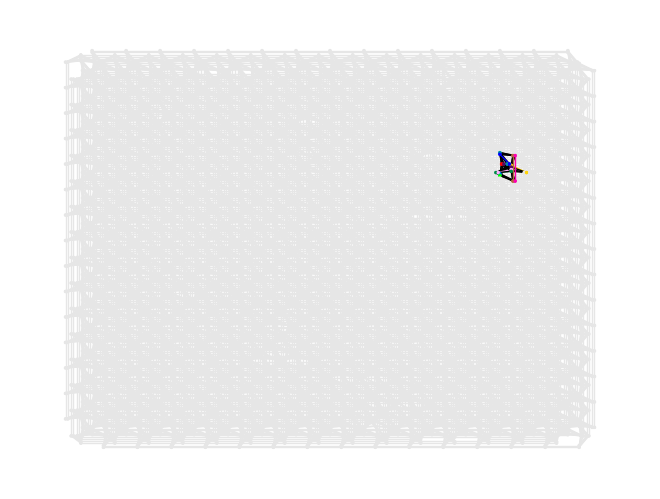

In [23]:
embedding = DWaveSamples.info['embedding_context']['embedding']
if qpu.solver.id == "DW_2000Q_6":
  dnx.draw_chimera_embedding(X, embedding, node_size=2)
elif qpu.solver.id == "Advantage_system1.1":
  dnx.draw_pegasus_embedding(X, embedding, node_size=2)
elif qpu.solver.id == "Advantage_system4.1":
  dnx.draw_pegasus_embedding(X, embedding, node_size=2)

minimum energy: 5.0


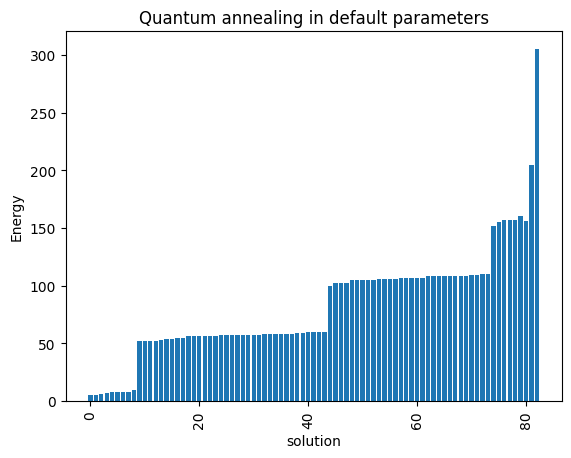

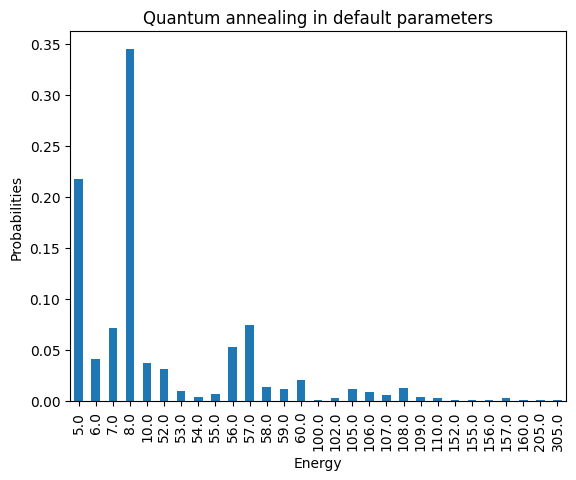

minimum energy: 5.0


In [24]:
plot_enumerate(DWaveSamples, title='Quantum annealing in default parameters')
plot_energies(DWaveSamples, title='Quantum annealing in default parameters')

Now we can play with the other parameters such as Annealing time, chain strenght, and annealing schedule to improve the performance of D-Wave's Quantum Annealing.